In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import datascience as ds
np.random.seed(42)  
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,10)
plt.style.use('fivethirtyeight')

## Data processing

In [5]:
pm = "https://raw.githubusercontent.com/Dr-Isam-ALJAWARNEH/ds-project-clustering-AQ-data/main/data/NYC_Pilot2_PM_Part1.csv?token=GHSAT0AAAAAACOQ2HNSGHS35TKOXLXRJWLKZRKCGOA"
pmdata = pd.read_csv('NYC_Pilot2_PM_Part1.csv') #contents of data)
pmdata.head()

SensorID        time   latitude  longitude  bin0  bin1  bin2  bin3  \
0  NYCP2_CS01A  1631277304  40.847672 -73.869316    11     1     1     0   
1  NYCP2_CS01A  1631277308  40.847668 -73.869316    22     4     1     0   
2  NYCP2_CS01A  1631277313  40.847649 -73.869362    40     1     1     0   
3  NYCP2_CS01A  1631277318  40.847649 -73.869362    26     1     0     0   
4  NYCP2_CS01A  1631277323  40.847649 -73.869362    44     4     0     1   

   bin4  bin5  ...  bin17  bin18  bin19  bin20  bin21  bin22  bin23  \
0     0     0  ...      0      0      0      0      0      0      0   
1     0     2  ...      0      0      0      0      0      0      0   
2     0     1  ...      0      0      0      0      0      0      0   
3     0     0  ...      0      0      0      0      0      0      0   
4     0     0  ...      0      0      0      0      0      0      0   

   temperature  humidity      pm25  
0         23.7      57.3  4.508813  
1         23.7      57.8  5.462420  
2         23.7      57.8  5.154881  
3         23.6      57.6  4.508813  
4         23.6      57.5  5.539503  

[5 rows x 31 columns]

In [6]:
pmdata = \
pmdata[(pmdata['latitude']!=0) & \
       (pmdata['longitude'] !=0)]

In [7]:
#!pip install pygeohash
import  pygeohash as gh


In [8]:
geohash_precision=6
pmdata['geohash'] = pmdata.apply(lambda x:gh.encode(x.latitude, x.longitude, precision=geohash_precision), axis=1)

In [9]:
gdf_pm25=gpd.GeoDataFrame(pmdata, geometry=gpd.points_from_xy(pmdata.longitude, pmdata.latitude))
gdf_pm25=gdf_pm25.set_crs(epsg=4326) 

In [10]:
geojsonfile = "https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson"
# Create a GeoDataFrame from the DataFrame by converting lat/lon to geometry
gdf_neighbourhoods = gpd.read_file(geojsonfile)
gdf_neighbourhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
from geopandas.tools import sjoin
# Perform spatial join
joined_gdf_pm25 = sjoin(gdf_pm25, gdf_neighbourhoods, predicate="within")
joined_gdf_pm25.head()

SensorID        time   latitude  longitude  bin0  bin1  bin2  bin3  \
0  NYCP2_CS01A  1631277304  40.847672 -73.869316    11     1     1     0   
1  NYCP2_CS01A  1631277308  40.847668 -73.869316    22     4     1     0   
2  NYCP2_CS01A  1631277313  40.847649 -73.869362    40     1     1     0   
3  NYCP2_CS01A  1631277318  40.847649 -73.869362    26     1     0     0   
4  NYCP2_CS01A  1631277323  40.847649 -73.869362    44     4     0     1   

   bin4  bin5  ...  temperature  humidity      pm25  geohash  \
0     0     0  ...         23.7      57.3  4.508813   dr72rh   
1     0     2  ...         23.7      57.8  5.462420   dr72rh   
2     0     1  ...         23.7      57.8  5.154881   dr72rh   
3     0     0  ...         23.6      57.6  4.508813   dr72rh   
4     0     0  ...         23.6      57.5  5.539503   dr72rh   

                     geometry  index_right  neighborhood  boroughCode  \
0  POINT (-73.86932 40.84767)           38    Bronx Park            2   
1  POINT (-73.86932 40.84767)           38    Bronx Park            2   
2  POINT (-73.86936 40.84765)           38    Bronx Park            2   
3  POINT (-73.86936 40.84765)           38    Bronx Park            2   
4  POINT (-73.86936 40.84765)           38    Bronx Park            2   

   borough                                                @id  
0    Bronx  http://nyc.pediacities.com/Resource/Neighborho...  
1    Bronx  http://nyc.pediacities.com/Resource/Neighborho...  
2    Bronx  http://nyc.pediacities.com/Resource/Neighborho...  
3    Bronx  http://nyc.pediacities.com/Resource/Neighborho...  
4    Bronx  http://nyc.pediacities.com/Resource/Neighborho...  

[5 rows x 38 columns]

In [12]:
type(joined_gdf_pm25)

geopandas.geodataframe.GeoDataFrame

In [13]:
joined_gdf_pm25.shape

(169995, 38)

In [14]:
n=len(pd.unique(joined_gdf_pm25['neighborhood']))
n

48

In [15]:
# Select columns to copy
columns_to_copy = ['neighborhood','latitude', 'longitude', 'pm25']  # Replace with the names of the 
new_joined_gdf_pm25_2 = joined_gdf_pm25[columns_to_copy].copy()
type(new_joined_gdf_pm25_2)

pandas.core.frame.DataFrame

## Data Visualization

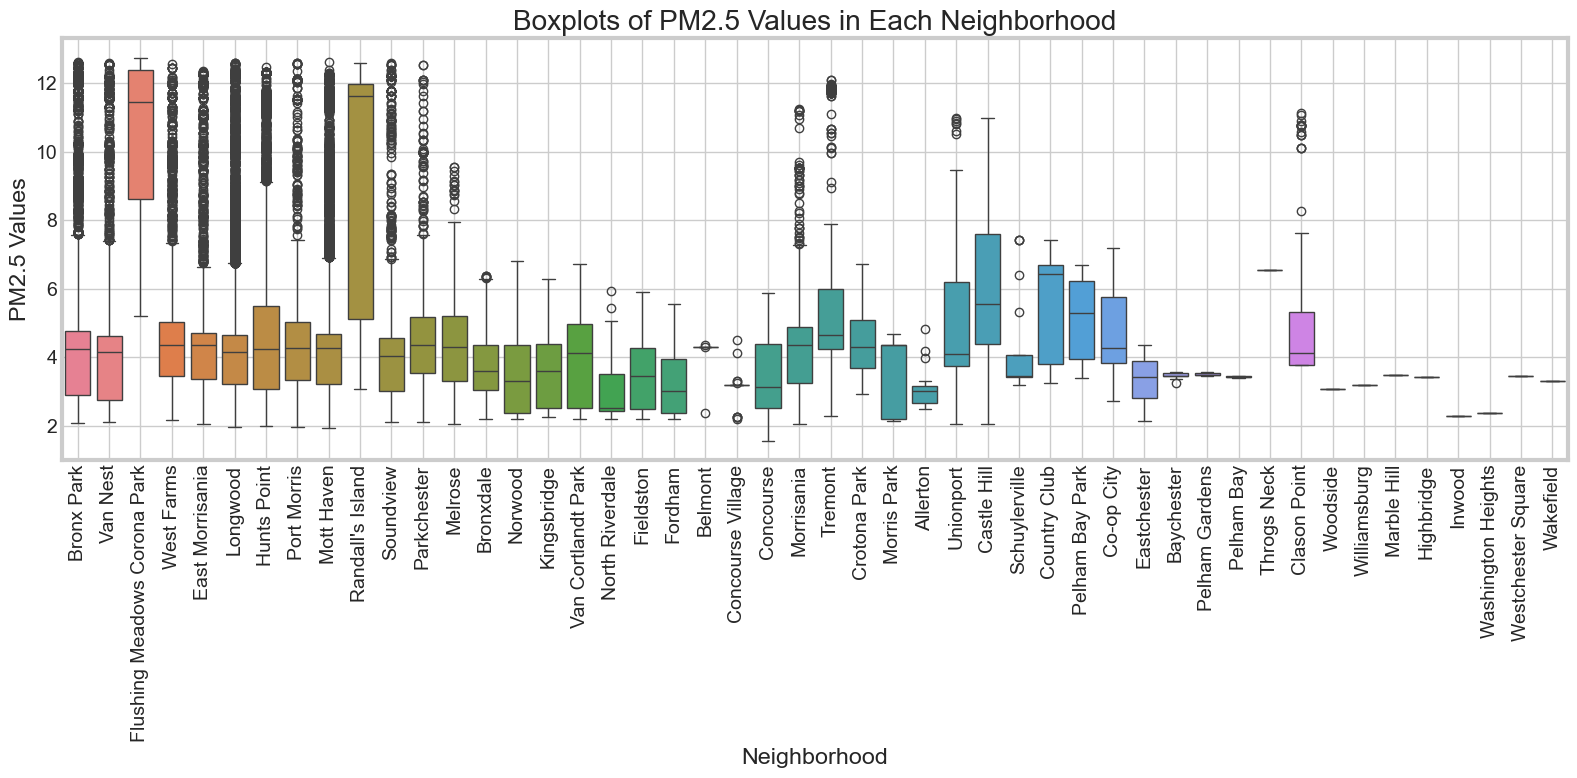

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the seaborn plots
sns.set_style("whitegrid")

# Plot boxplots for PM2.5 values in each neighborhood
plt.figure(figsize=(16, 8))  # Set a wider figure size

sns.boxplot(data=new_joined_gdf_pm25_2, x='neighborhood', y='pm25', hue='neighborhood')

# Add labels and title
plt.xlabel('Neighborhood')
plt.ylabel('PM2.5 Values')
plt.title('Boxplots of PM2.5 Values in Each Neighborhood')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


## Sampling Data

In [18]:
sample_base= new_joined_gdf_pm25_2.groupby('neighborhood', group_keys=False).apply(lambda x: x.sample(frac=0.6))
print('sample size:',sample_base.shape)
sample_base.head()

sample size: (101999, 4)


neighborhood   latitude  longitude      pm25
95515     Allerton  40.862942 -73.866005  2.674112
95438     Allerton  40.858326 -73.867920  3.274350
95474     Allerton  40.862965 -73.866020  3.019981
95503     Allerton  40.862926 -73.866035  3.031712
95444     Allerton  40.858330 -73.867882  3.310334

In [19]:
sample2=sample_base['neighborhood'].value_counts()
sample2=sample2.reset_index()
sample2.colums=['neighborhood','count']
sample2['neighborhood']=sample2['neighborhood'].astype(str)
sample2.head(2)

C:\Users\Manar Anwer\AppData\Local\Temp\ipykernel_40992\3871528025.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sample2.colums=['neighborhood','count']


neighborhood  count
0     Longwood  25514
1   Bronx Park  23697

In [20]:
original=joined_gdf_pm25['neighborhood'].value_counts()
original=original.reset_index()
original.colums=['neighborhood','count']
original['neighborhood']=original['neighborhood'].astype(str)
original.head(2)

C:\Users\Manar Anwer\AppData\Local\Temp\ipykernel_40992\887117895.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  original.colums=['neighborhood','count']


neighborhood  count
0     Longwood  42523
1   Bronx Park  39495

In [21]:
import folium
original["neighborhood"].astype(str)
geojsonfile=pm = "https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson"
heatmap_scale=list()
threshold=[10,20,50,70,85,100]
for i in threshold:
    heatmap_scale.append(int(original['count'].max()*(i/100.0)))
map_original=folium.Map(location=[40.730610,-73.935242], zoom_start=10)
#Create choropleth map object with key on TOWNNAME
folium.Choropleth(geo_data = geojsonfile,#Assign geo_data to your geojson file
    name = "choropleth",
    data = original,#Assign dataset of interest
    columns = ["neighborhood","count"],#Assign columns in the dataset for plotting
    key_on = 'feature.properties.neighborhood',#Assign the key that geojson uses to connect with dataset
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.5,
    legend_name = 'neighborhood').add_to(map_original)

map_original


In [22]:
import folium
sample2["neighborhood"].astype(str)
geojsonfile=pm = "https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson"
heatmap_scale=list()
threshold=[10,20,50,70,85,100]
for i in threshold:
    heatmap_scale.append(int(sample2['count'].max()*(i/100.0)))
map_sample2=folium.Map(location=[40.730610,-73.935242], zoom_start=10)
#Create choropleth map object with key on TOWNNAME
folium.Choropleth(geo_data = geojsonfile,#Assign geo_data to your geojson file
    name = "choropleth",
    data = sample2,#Assign dataset of interest
    columns = ["neighborhood","count"],#Assign columns in the dataset for plotting
    key_on = 'feature.properties.neighborhood',#Assign the key that geojson uses to connect with dataset
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.5,
    legend_name = 'neighborhood').add_to(map_sample2)

map_sample2

from the above two maps we can see that our sample is actually representative of the population that we have. 

## Feature Scaling

In [35]:
from sklearn.preprocessing import StandardScaler
feature_columns = ["latitude", "longitude","pm25"]
# Scale these features
scaler = StandardScaler()
scaled_features=scaler.fit_transform(sample_base[feature_columns])
scaled_features

array([[ 2.13381395,  1.37125569, -0.91071308],
       [ 1.86582837,  1.2724642 , -0.57637899],
       [ 2.13514923,  1.37048186, -0.71806273],
       ..., 
       [ 0.78993825,  2.26940701, -0.47039276],
       [-6.64730024, -2.13916956, -0.62487717],
       [-4.94887776, -0.32114825, -0.68230261]])

## K-means

In [114]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_features)

samplek=sample_base.copy()
samplek.loc[:, 'label'] = kmeans.labels_
samplek.head()

neighborhood   latitude  longitude      pm25  label
95515     Allerton  40.862942 -73.866005  2.674112      1
95438     Allerton  40.858326 -73.867920  3.274350      1
95474     Allerton  40.862965 -73.866020  3.019981      1
95503     Allerton  40.862926 -73.866035  3.031712      1
95444     Allerton  40.858330 -73.867882  3.310334      1

In [115]:
samplek.groupby('label').size()

label
0    59169
1    34317
2     8513
dtype: int64

In [ ]:
type(gdf_neighbourhoods)

In [ ]:
gdf_neighbourhoods.head()

In [ ]:
type(samplek)

In [ ]:
samplek.head()

In [116]:
import geopandas as gpd
gdf_pm25_result_k = gdf_neighbourhoods.merge(samplek, left_on='neighborhood', right_on='neighborhood', how='left')
gdf_pm25_result_k['label'] = gdf_pm25_result_k['label'].fillna(-1)
type(gdf_pm25_result_k)

geopandas.geodataframe.GeoDataFrame

In [ ]:
type(gdf_pm25_result_k)

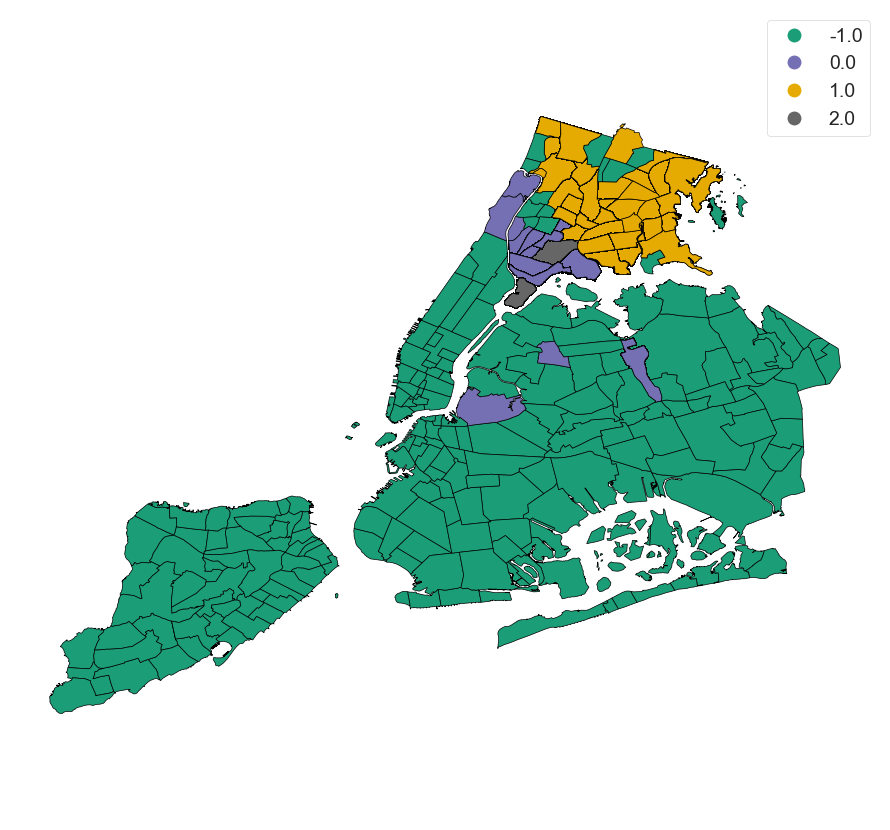

In [117]:
# setup the figure
f, ax = plt.subplots()

# plot, coloring by label column
# specify categorical data and add legend
gdf_pm25_result_k.plot(
    column="label",
    cmap="Dark2",
    categorical=True,
    legend=True,
    edgecolor="k",
    lw=0.5,
    ax=ax,
)


ax.set_axis_off()
plt.axis("equal");

## Silhouette Index for K-means


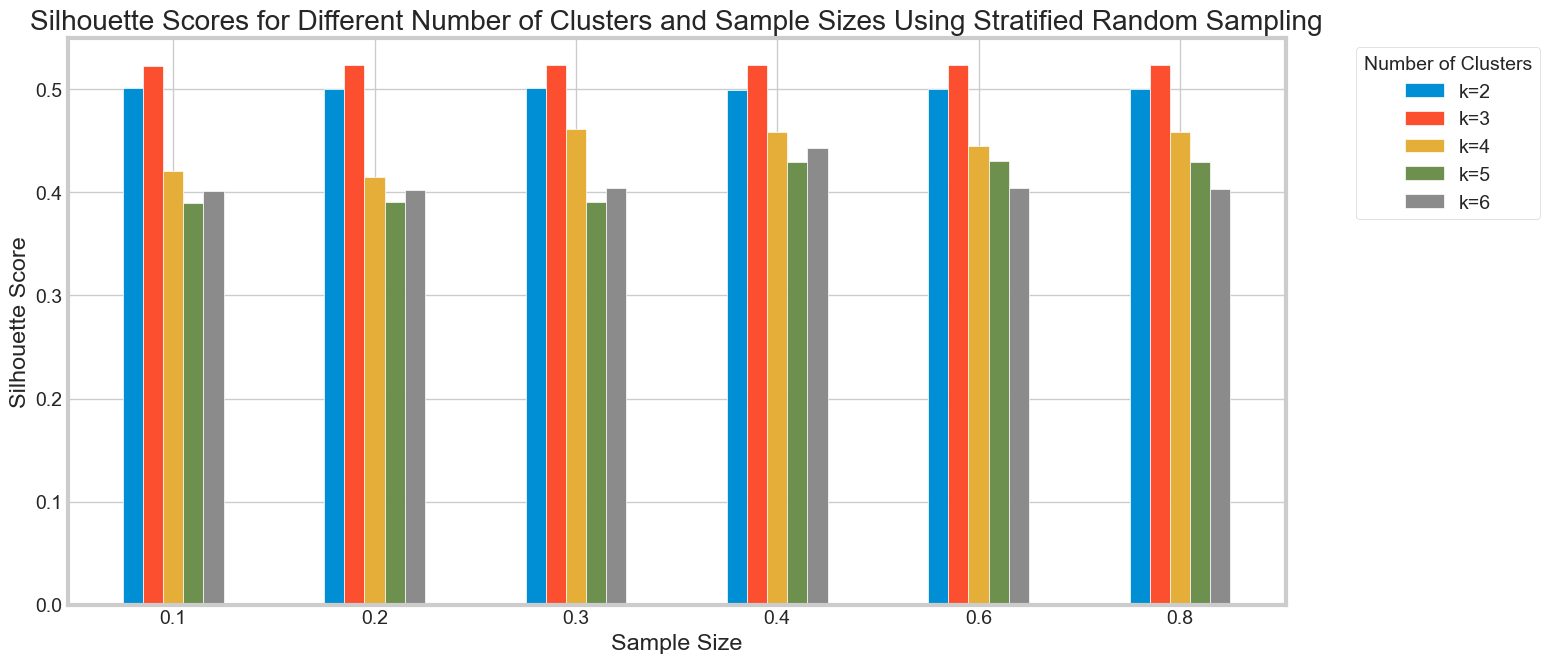

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming 'df_final' is your DataFrame containing the data

# Define sample ratios and number of clusters (k) to test
sample_ratios = [0.1, 0.2, 0.3, 0.4, 0.6, 0.8]
k_values = [2, 3, 4, 5, 6]  # Different number of clusters to test
silhouette_results = {k: [] for k in k_values}

# Scale the features of the entire dataset
scaler = StandardScaler()
# Create KMeans object for reuse
kmeans = KMeans(random_state=1)

# Iterate over each number of clusters
for k in k_values:
    kmeans.set_params(n_clusters=k)
    # Now iterate over each sample ratio
    for ratio in sample_ratios:
        # Sample a fraction of the data based on the ratio
        sampled_data = new_joined_gdf_pm25_2.groupby('neighborhood', group_keys=False).apply(lambda x: x.sample(frac=ratio))
        features_samples = sampled_data[['pm25', 'longitude', 'latitude']]

        # Scale the features of the sample
        features_scaled_sample = scaler.fit_transform(features_samples)

        # Check if we have enough samples to form the specified number of clusters
        if len(features_scaled_sample) >= k:
            labels = kmeans.fit_predict(features_scaled_sample)
            # Calculate silhouette score only if there are more than 1 cluster
            if len(set(labels)) > 1:
                silhouette_avg = silhouette_score(features_scaled_sample, labels)
                silhouette_results[k].append(silhouette_avg)

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 7))

# Create a bar chart with grouped bars for each sample ratio
bar_width = 0.1
index = np.arange(len(sample_ratios))

for i, (k, scores) in enumerate(silhouette_results.items()):
    # Offset each k's bar by the width
    ax.bar(index + i * bar_width, scores, bar_width, label=f'k={k}')

ax.set_xlabel('Sample Size')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Scores for Different Number of Clusters and Sample Sizes Using Stratified Random Sampling')
ax.set_xticks(index + bar_width * (len(k_values) - 1) / 2)
ax.set_xticklabels(sample_ratios)
ax.legend(title='Number of Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


## DBSCAN

In [40]:
sample_base.head()

neighborhood   latitude  longitude      pm25
95515     Allerton  40.862942 -73.866005  2.674112
95438     Allerton  40.858326 -73.867920  3.274350
95474     Allerton  40.862965 -73.866020  3.019981
95503     Allerton  40.862926 -73.866035  3.031712
95444     Allerton  40.858330 -73.867882  3.310334

In [41]:
scaled_features

array([[ 2.13381395,  1.37125569, -0.91071308],
       [ 1.86582837,  1.2724642 , -0.57637899],
       [ 2.13514923,  1.37048186, -0.71806273],
       ..., 
       [ 0.78993825,  2.26940701, -0.47039276],
       [-6.64730024, -2.13916956, -0.62487717],
       [-4.94887776, -0.32114825, -0.68230261]])

In [110]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.9, min_samples=50)  # You can adjust min_samples according to your data
labels = dbscan.fit_predict(scaled_features)
sampleDB=sample_base.copy()
sampleDB.loc[:, 'label'] =labels
sampleDB.head()

neighborhood   latitude  longitude      pm25  label
95515     Allerton  40.862942 -73.866005  2.674112      0
95438     Allerton  40.858326 -73.867920  3.274350      0
95474     Allerton  40.862965 -73.866020  3.019981      0
95503     Allerton  40.862926 -73.866035  3.031712      0
95444     Allerton  40.858330 -73.867882  3.310334      0

In [111]:
gdf_pm25_result_DB = gdf_neighbourhoods.merge(sampleDB, left_on='neighborhood', right_on='neighborhood', how='left')
# assign -1 to the neighborhoods without any listings
gdf_pm25_result_DB['label'] = gdf_pm25_result_DB['label'].fillna(-1)
gdf_pm25_result_DB

neighborhood boroughCode        borough  \
0              Allerton           2          Bronx   
1              Allerton           2          Bronx   
2              Allerton           2          Bronx   
3              Allerton           2          Bronx   
4              Allerton           2          Bronx   
...                 ...         ...            ...   
102318  Windsor Terrace           3       Brooklyn   
102319        Woodhaven           4         Queens   
102320         Woodlawn           2          Bronx   
102321          Woodrow           5  Staten Island   
102322         Woodside           4         Queens   

                                                      @id  \
0       http://nyc.pediacities.com/Resource/Neighborho...   
1       http://nyc.pediacities.com/Resource/Neighborho...   
2       http://nyc.pediacities.com/Resource/Neighborho...   
3       http://nyc.pediacities.com/Resource/Neighborho...   
4       http://nyc.pediacities.com/Resource/Neighborho...   
...                                                   ...   
102318  http://nyc.pediacities.com/Resource/Neighborho...   
102319  http://nyc.pediacities.com/Resource/Neighborho...   
102320  http://nyc.pediacities.com/Resource/Neighborho...   
102321  http://nyc.pediacities.com/Resource/Neighborho...   
102322  http://nyc.pediacities.com/Resource/Neighborho...   

                                                 geometry   latitude  \
0       POLYGON ((-73.84860 40.87167, -73.84582 40.870...  40.862942   
1       POLYGON ((-73.84860 40.87167, -73.84582 40.870...  40.858326   
2       POLYGON ((-73.84860 40.87167, -73.84582 40.870...  40.862965   
3       POLYGON ((-73.84860 40.87167, -73.84582 40.870...  40.862926   
4       POLYGON ((-73.84860 40.87167, -73.84582 40.870...  40.858330   
...                                                   ...        ...   
102318  POLYGON ((-73.98006 40.66075, -73.97988 40.660...        NaN   
102319  POLYGON ((-73.86233 40.69596, -73.85654 40.697...        NaN   
102320  POLYGON ((-73.85947 40.90052, -73.85926 40.900...        NaN   
102321  POLYGON ((-74.17728 40.54063, -74.17723 40.539...        NaN   
102322  POLYGON ((-73.90087 40.75767, -73.90014 40.756...  40.740944   

        longitude      pm25  label  
0      -73.866005  2.674112    0.0  
1      -73.867920  3.274350    0.0  
2      -73.866020  3.019981    0.0  
3      -73.866035  3.031712    0.0  
4      -73.867882  3.310334    0.0  
...           ...       ...    ...  
102318        NaN       NaN   -1.0  
102319        NaN       NaN   -1.0  
102320        NaN       NaN   -1.0  
102321        NaN       NaN   -1.0  
102322 -73.898811  3.084182   -1.0  

[102323 rows x 9 columns]

In [112]:
gdf_pm25_result_DB.groupby('label').size()
# we have 22 clusters

label
-1.0       401
 0.0    101558
 1.0       235
 2.0       129
dtype: int64

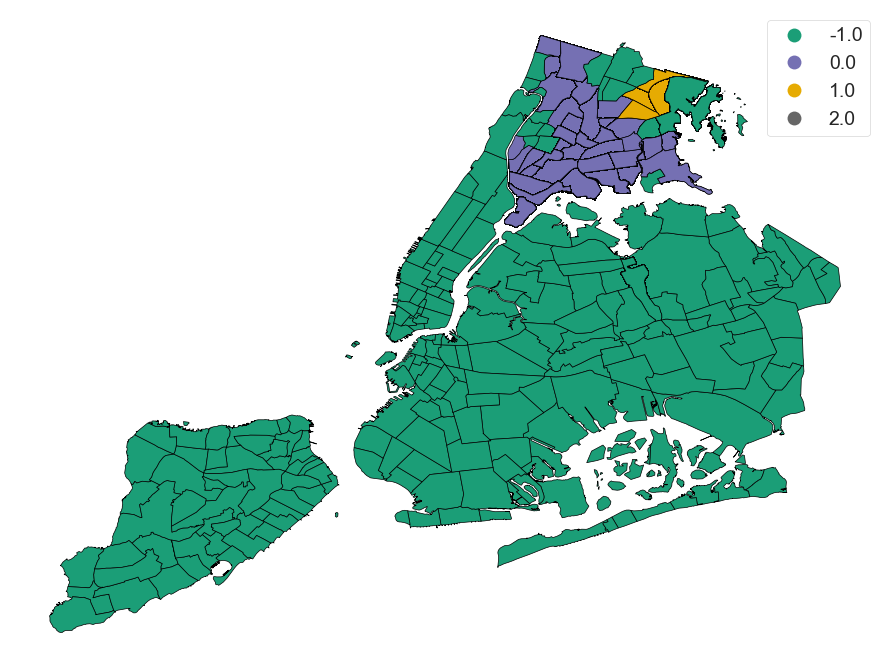

In [113]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))
#cmap = plt.cm.get_cmap('tab20')

# Plot, coloring by label column
# Specify categorical data and add legend
gdf_pm25_result_DB.plot(
    column="label",
    cmap='Dark2',
    categorical=True,
    legend=True,
    edgecolor="k",
    lw=0.5,
    ax=ax,
)

# Remove axis
ax.set_axis_off()
plt.axis("equal")

# Show the plot
plt.show()


## Silhouette Index for DBSCAN


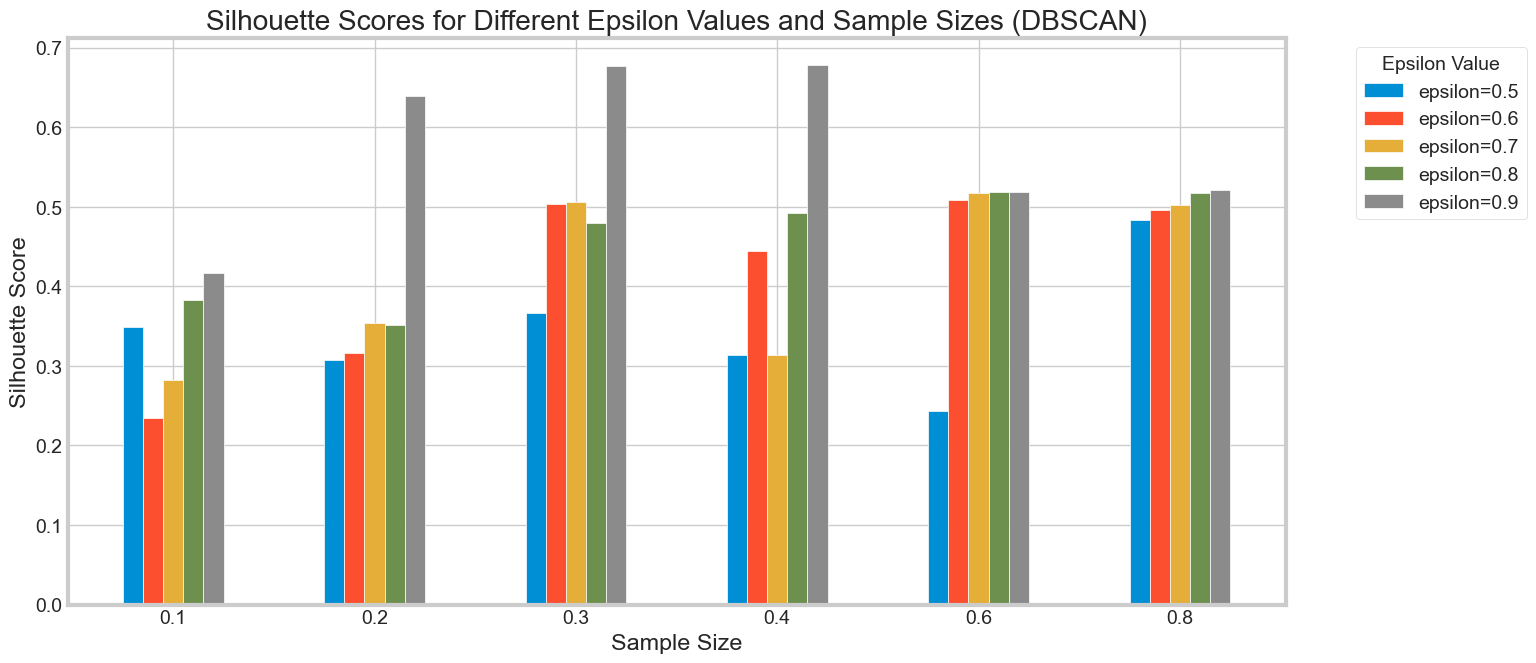

In [107]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming 'new_joined_gdf_pm25_2' is your DataFrame containing the data

# Define sample ratios and epsilon values to test
sample_ratios = [0.1, 0.2, 0.3, 0.4, 0.6, 0.8]
epsilon_values = [0.5, 0.6, 0.7, 0.8, 0.9]  # Different epsilon values to test
silhouette_results = {epsilon: [] for epsilon in epsilon_values}

# Scale the features of the entire dataset
scaler = StandardScaler()
features_scaled = scaler.fit_transform(new_joined_gdf_pm25_2[['pm25', 'longitude', 'latitude']])

# Iterate over each epsilon value
for epsilon in epsilon_values:
    # Now iterate over each sample ratio
    for ratio in sample_ratios:
        # Sample a fraction of the data based on the ratio
        sampled_data = new_joined_gdf_pm25_2.groupby('neighborhood', group_keys=False).apply(lambda x: x.sample(frac=ratio))
        features_samples = sampled_data[['pm25', 'longitude', 'latitude']]

        # Scale the features of the sample
        features_scaled_sample = scaler.transform(features_samples)

        # Run DBSCAN clustering on the sampled and scaled features
        dbscan = DBSCAN(eps=epsilon, min_samples=50)  # You can adjust min_samples according to your data
        labels = dbscan.fit_predict(features_scaled_sample)

        # Calculate silhouette score only if there are more than 1 cluster (ignoring noise points)
        if len(set(labels)) > 1:
            silhouette_avg = silhouette_score(features_scaled_sample, labels)
            silhouette_results[epsilon].append(silhouette_avg)
        else:
            silhouette_results[epsilon].append(None)  # Only noise points found

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 7))

# Create a bar chart with grouped bars for each epsilon value
bar_width = 0.1
index = np.arange(len(sample_ratios))

for i, (epsilon, scores) in enumerate(silhouette_results.items()):
    # Offset each epsilon's bar by the width
    ax.bar(index + i * bar_width, scores, bar_width, label=f'epsilon={epsilon}')

ax.set_xlabel('Sample Size')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Scores for Different Epsilon Values and Sample Sizes (DBSCAN)')
ax.set_xticks(index + bar_width * (len(epsilon_values) - 1) / 2)
ax.set_xticklabels(sample_ratios)
ax.legend(title='Epsilon Value', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [89]:
from sklearn.cluster import OPTICS

# Run OPTICS on the subset of scaled features
optics = OPTICS(min_samples=50, metric="euclidean")  # minimum sample size is set to 2
optics.fit(scaled_features)

sampleOp=sample_base
sampleOp.loc[:, 'label'] = optics.labels_
sampleOp.head()

neighborhood   latitude  longitude      pm25  label
95515     Allerton  40.862942 -73.866005  2.674112     -1
95438     Allerton  40.858326 -73.867920  3.274350     -1
95474     Allerton  40.862965 -73.866020  3.019981      0
95503     Allerton  40.862926 -73.866035  3.031712      0
95444     Allerton  40.858330 -73.867882  3.310334     -1

In [90]:
gdf_pm25_resul_Op = gdf_neighbourhoods.merge(sampleOp, left_on='neighborhood', right_on='neighborhood', how='left')
# assign -1 to the neighborhoods without any listings
gdf_pm25_resul_Op['label'] = gdf_pm25_resul_Op['label'].fillna(-1)

In [91]:
gdf_pm25_resul_Op.groupby('label', as_index=False).size()

label   size
0     -1.0  79358
1      0.0     51
2      1.0     53
3      2.0    116
4      3.0    130
..     ...    ...
257  256.0     64
258  257.0    111
259  258.0     75
260  259.0     53
261  260.0    169

[262 rows x 2 columns]

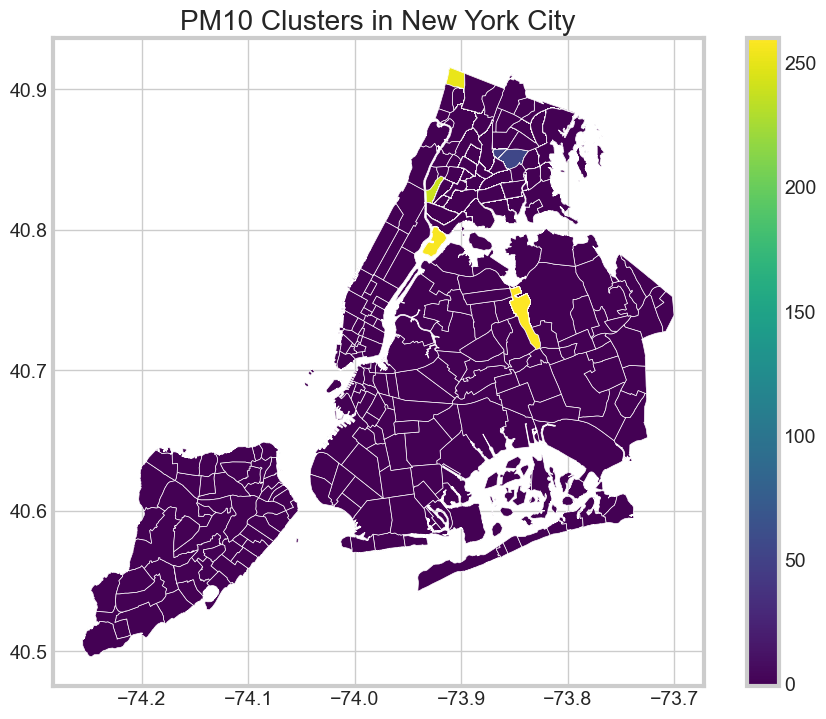

In [92]:
# Plot the choropleth map with cluster labels
fig, ax = plt.subplots(figsize=(10, 8))
gdf_pm25_resul_Op.plot(column='label', cmap='viridis', legend=True, ax=ax)
ax.set_title('PM10 Clusters in New York City')
plt.show()

## Silhouette Index for OPTICS

C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: 

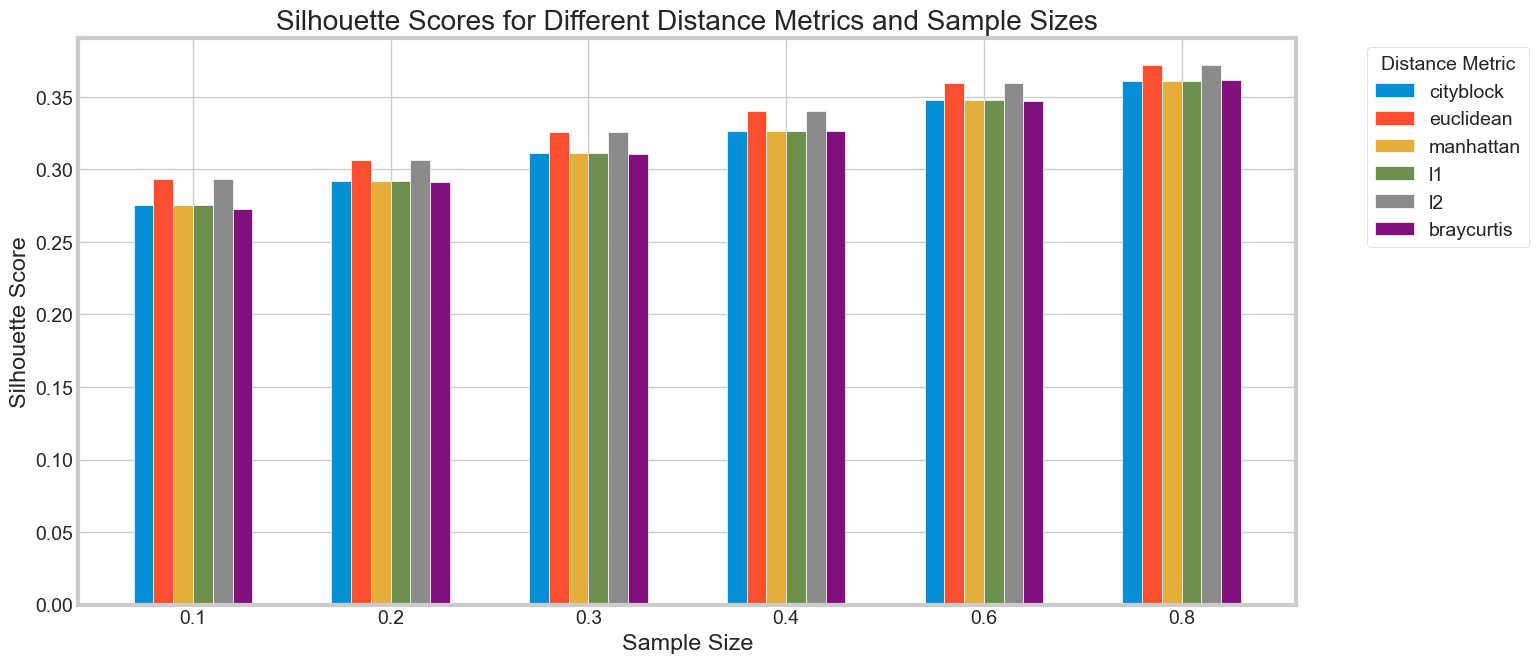

In [119]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define sample ratios and metrics to test
sample_ratios = [0.1, 0.2, 0.3, 0.4, 0.6, 0.8]
distance_metrics = ['cityblock', 'euclidean', 'manhattan', 'l1', 'l2', 'braycurtis']
silhouette_results = {metric: [] for metric in distance_metrics}

# Sample the data once for all iterations
pmdata_samples = pmdata.sample(frac=max(sample_ratios), random_state=1)

# Iterate over each distance metric
for metric in distance_metrics:
    # Scale the features of the sample
    scaler = StandardScaler()
    features_scaled_sample = scaler.fit_transform(pmdata_samples[['pm25', 'longitude', 'latitude']])

    # Iterate over each sample ratio
    for ratio in sample_ratios:
        # Get the subset of features based on the current sample ratio
        features_scaled_subset = features_scaled_sample[:int(len(features_scaled_sample) * ratio)]

        # Check if we have enough samples to form a cluster
        if len(features_scaled_subset) < 2:
            silhouette_avg = None  # Not enough samples to form a cluster
        else:
            # Run OPTICS on the subset of scaled features
            optics = OPTICS(min_samples=2, metric=metric)  # minimum sample size is set to 2
            optics.fit(features_scaled_subset)
            labels = optics.labels_

            # Calculate silhouette score only if there are clusters found
            if len(set(labels)) - (1 if -1 in labels else 0) > 1:
                silhouette_avg = silhouette_score(features_scaled_subset, labels)
            else:
                silhouette_avg = None  # No valid clusters found

        silhouette_results[metric].append(silhouette_avg)

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 7))

# Create a bar chart with grouped bars for each sample ratio
bar_width = 0.1
index = np.arange(len(sample_ratios))

for i, (metric, scores) in enumerate(silhouette_results.items()):
    # Offset each metric's bar by the width
    ax.bar(index + i * bar_width, scores, bar_width, label=metric)

ax.set_xlabel('Sample Size')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Scores for Different Distance Metrics and Sample Sizes')
ax.set_xticks(index + bar_width * (len(distance_metrics) - 1) / 2)
ax.set_xticklabels(sample_ratios)
ax.legend(title='Distance Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
